In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



d:\ads_enfit


In [2]:
from libs.common import *
from config.config import *
from models.models import VGG16, LSTM_model

d:\ads_enfit\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:/ads_enfit


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp2"
os.makedirs(save_dir, exist_ok=True)

In [4]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [5]:
# wandb.init(project="enefit_prediction_consumer")


In [6]:
X_train=pd.read_csv(f'{save_dir}/X_train.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid.csv', index_col=None)
X_test=pd.read_csv(f'{save_dir}/X_test.csv', index_col=None)
y_test=pd.read_csv(f'{save_dir}/y_test.csv', index_col=None)


In [7]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
X_test.drop(columns=['Unnamed: 0'], inplace=True)
y_test.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(1079454, 141) (1079454, 1) (531672, 141) (531672, 1) (6144, 141) (6144, 1)


In [8]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
lstm_model = LSTM_model(input_shape=(X_train.shape[1],1), activation='gelu').model
lr=0.0001
lstm_model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae', r2])
lstm_model.summary()

Model: "model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 141, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,265 (340.88 KB)

 Trainable params: 87,265 (340.88 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=2,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=1,
    min_lr=0.000001,
    verbose=1,
)
# checkpoint_callback = ModelCheckpoint(
#     filepath='LSTM1.hdf5', 
#     monitor='val_loss', 
#     mode='min',
#     save_best_only=True, 
#     verbose=1,  
#     save_format="tf"
# )

In [11]:
lstm_model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=32,epochs= 10000, callbacks=[early_stopping,lr_scheduler])

Epoch 1/10000
33733/33733 ━━━━━━━━━━━━━━━━━━━━ 1758s 52ms/step - loss: 304627.8125 - mae: 146.0556 - r2: 0.4699 - val_loss: 315147.2188 - val_mae: 138.0736 - val_r2: 0.7668 - learning_rate: 1.0000e-04
Epoch 2/10000
33733/33733 ━━━━━━━━━━━━━━━━━━━━ 1875s 56ms/step - loss: 150595.1250 - mae: 114.1275 - r2: 0.6119 - val_loss: 133205.2188 - val_mae: 112.7904 - val_r2: 0.8242 - learning_rate: 1.0000e-04
Epoch 3/10000
33733/33733 ━━━━━━━━━━━━━━━━━━━━ 1969s 58ms/step - loss: 135856.3906 - mae: 109.2733 - r2: 0.6334 - val_loss: 124934.0938 - val_mae: 98.4484 - val_r2: 0.8677 - learning_rate: 1.0000e-04
Epoch 4/10000
33733/33733 ━━━━━━━━━━━━━━━━━━━━ 2150s 64ms/step - loss: 130731.3516 - mae: 106.4360 - r2: 0.6611 - val_loss: 100775.5547 - val_mae: 92.3587 - val_r2: 0.8707 - learning_rate: 1.0000e-04
Epoch 5/10000
33733/33733 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 121368.3125 - mae: 102.7628 - r2: 0.6906
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
33733/33733 ━

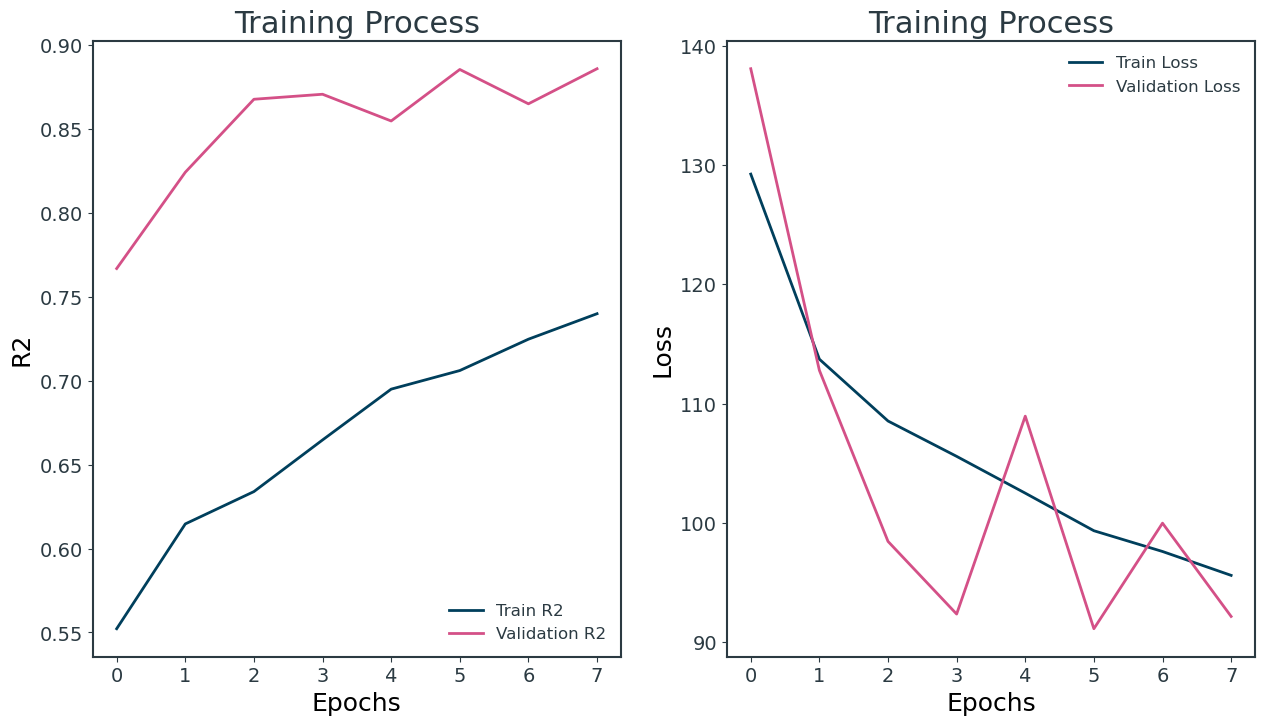

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

history = lstm_model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train R2')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation R2')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('R2')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [13]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = lstm_model.predict(X_test)

# Tính toán R2 Score
r2 = r2_score(y_test, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")


192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step
R2 Score: 0.8223065137863159
MAE: 135.07659790944183
